# Test Algorithm 1 on MNIST dataset

In [102]:
#!rm -rf code
#!git clone https://xxxx/yyyy.git code
#!mv code/* .
%load_ext autoreload
%autoreload 2
%matplotlib inline
from helpers import *
from matplotlib import pyplot as plt
import numpy as np
from experiment_datasets import *
import pandas as pd
import seaborn as sns
import pickle
from IPython.display import clear_output
from copy import deepcopy
import matplotlib
from scipy.optimize import curve_fit
from derivative_decay import get_metrics, dataset_metrics, show_neurons_1, show_W_profile
from collections import OrderedDict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

In [13]:
# pfailure for the first layer
p = 1e-2
np.random.seed(42)

In [14]:
# alpha from the proof
alpha = np.e ** 2.5 * p
assert alpha < 1, "Must have a non-trivial guarantee on weight perturbation"
print("Alpha P3", alpha)

# TARGET desired probability of failure
delta_target = 1e-5

# TARGET loss perturbation (will guarantee it happens with prob. at most delta_target)
eps_target = 0.009

print("Will guarantee eps=%.2f delta=%.6f" % (eps_target, delta_target))

Alpha P3 0.12182493960703472
Will guarantee eps=0.01 delta=0.000010


In [15]:
def get_exp(N = 50, mu = 1, lambda_ = 0.0, psi_d = 0, psi_s = 0, nu = 0, epochs = 30, do_print = 'plot'):
    """ Train a network with given size N and compute mean FT variance
         Returns: dict mean -> mean error on example, std -> std error on example, q -- q factor
    """
    K.clear_session()
    
    # run with random weights and multiple inputs
    exp = MNISTExperiment(N = [N, 100], p_inference = [0, p, 0, 0], seed = int(np.random.random() * 100000),
                                  activation = 'sigmoid', epochs = epochs, do_print = do_print, batch_size = 1000,
                                  reg_spec = {'balanced': mu,
                                              'vardelta': {'p': p, 'lambda': lambda_},
                                              'l1': nu,
                                              'continuous': [psi_d, psi_s]
                                             })
    
    return exp

In [16]:
# obtaining some experiment for x, y
exp = get_exp(N = 10, epochs = 1, do_print = False)

# obtaining one input
x = exp.x_train[0:1]
y = exp.y_train[0:1]

In [17]:
def q_factor_v(vect):
    """ q = v^min/v^min, see the main paper """
    vect = np.abs(vect)
    assert np.max(vect) > 0, "Cannot compute for vector of zeros """
    return np.min(vect) / np.max(vect)

def q_factor_l1(exp):
    """ q-factor for layer 1 of an experiment """
    W = exp.W[0]
    
    # here taking sum for 1st axis since it's not transposed here
    q = q_factor_v(np.sum(np.abs(W), axis = 1))
    
    return {'q_1': q}

def d_kl(a, b):
    """ KL-divergence between numbers """
    a, b = float(a), float(b)
    return a * np.log(a / b) + (1 - a) * np.log((1 - a) / (1 - b))

def estimate_experimental_error(exp, repetitions = 10000):
    """ Estimate experimental Delta on x, y """
    def experimental_error(exp):
        """ Experimental delta_L+1 on input x, y """
        return exp.get_mse_crash_data(x, y, repetitions = 1) - exp.get_mse_correct_data(x, y)

    # the experimental error
    dta = [experimental_error(exp) for _ in range(repetitions)]
    
    # histogram of experimental error
    plt.hist(dta, label = 'Experimental error')
    plt.axvline(eps_target, label = 'Target threshold', color = 'red')
    plt.legend()
    plt.xlabel('$\Delta$')
    plt.ylabel('Frequency')
    plt.show()
    
    # empirical probability of failure
    delta_empirical = np.mean(np.array(dta) > eps_target)
    
    return {'_exp_error_mse': dta,
           'exp_mse_mean': np.mean(dta),
           'exp_mse_std': np.std(dta),
           'empirical_p': delta_empirical}

def estimate_theoretical_error(exp):
    """ Estimate bound Delta on x, y """
    r = exp._get_bound_b3_loss(x, y)
    return {'bound_mse_mean': r['mean'],
           'bound_mse_std': r['std']}

def continuity(exp):
    """ Compute maximal derivative """
    result_d = []
    result_s = []
    sess = get_session()
    obj = Continuous(1, 1)
    for w in exp.model_correct.weights[0::2]:
        R = sess.run(obj(w, return_dict = True))
        result_d.append(R['derivative'])
        result_s.append(R['smoothness'])
    return {'derivative': result_d[0], 'smoothness': result_s[0]}

In [18]:
# list of things to run
to_run = [dataset_metrics, show_neurons_1, q_factor_l1, estimate_experimental_error, estimate_theoretical_error, continuity, show_W_profile]

In [19]:
# all parameters
parameters = {'N': 1, 'mu': 1e-10, 'lambda_': 1e-10, 'nu': 0, 'psi_d': 1e-8, 'psi_s': 1e-6}

In [20]:
def inc_n():
    """ Increase the number of neurons """
    global N
    parameters['N'] += 100

In [21]:
# list of visited parameter configurations
log = []

Trying parameters {'N': 1, 'mu': 1e-10, 'lambda_': 1e-10, 'nu': 0, 'psi_d': 1e-08, 'psi_s': 1e-06}


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


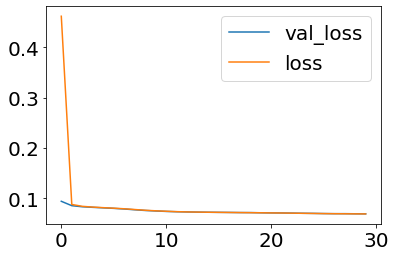

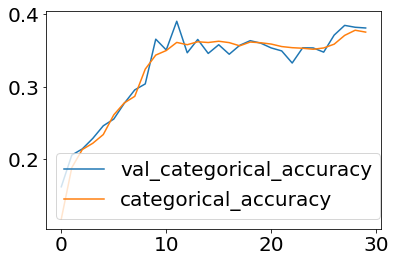

{'val_acc': 0.3813000023365021, 'train_acc': 0.37561666667461396, 'val_loss': 0.06957444325089454, 'train_loss': 0.06940705589950084}


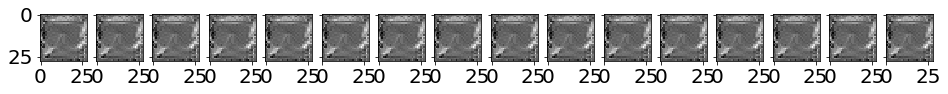

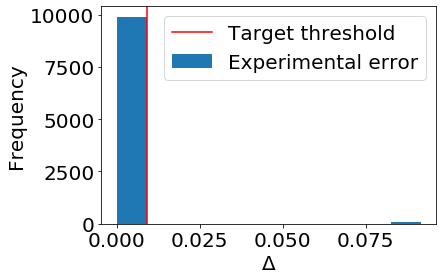

Layer 0


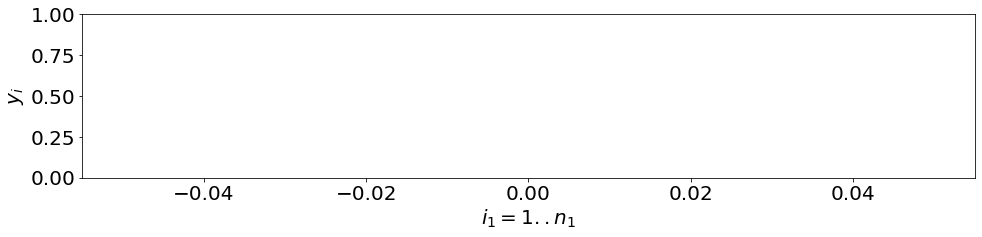

IntDer, Conv {'derivative': 0.0, 'smoothness': 0.0}
Layer 1


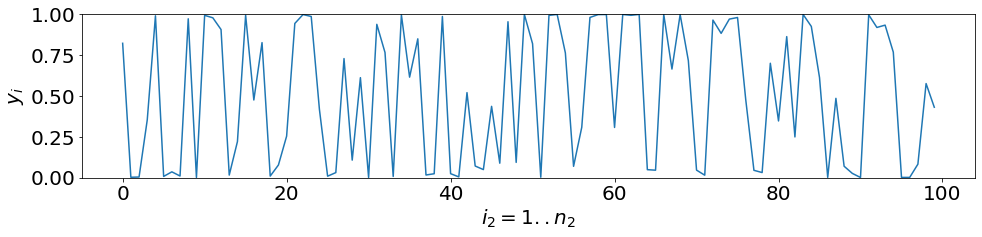

IntDer, Conv {'derivative': 134.29926, 'smoothness': 0.8458892}
Layer 2


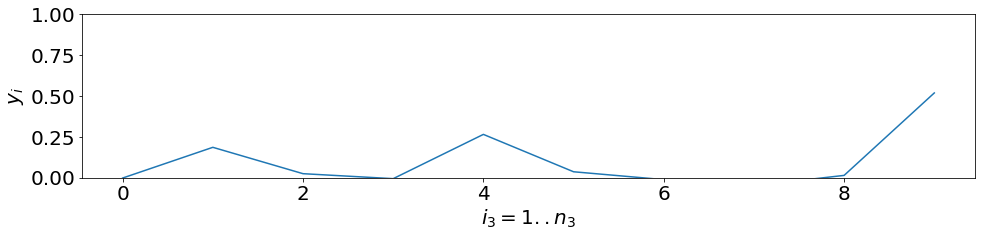

IntDer, Conv {'derivative': 71.50533, 'smoothness': 0.0}
True ans #0 5
P_empirical 0.01
q 1.00 D 0.00 S 0.00
Bound Mean 0.000 Std 0.003
Exp   Mean 0.001 Std 0.009
Perturbation must be small but delta_0=0.819300, consider increasing n
Trying parameters {'N': 101, 'mu': 1e-10, 'lambda_': 1e-10, 'nu': 0, 'psi_d': 1e-08, 'psi_s': 1e-06}


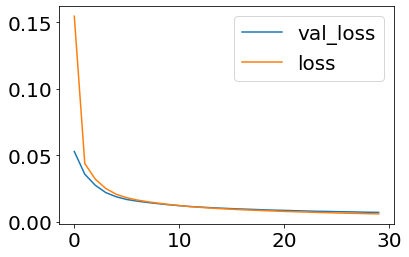

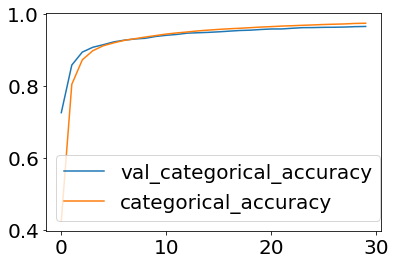

{'val_acc': 0.9650999963283539, 'train_acc': 0.9740666697422663, 'val_loss': 0.0071276267757639285, 'train_loss': 0.005976436093139152}


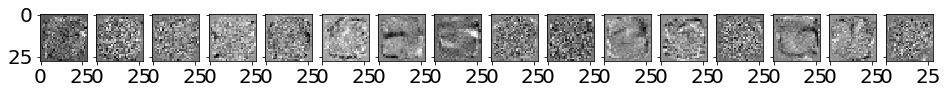

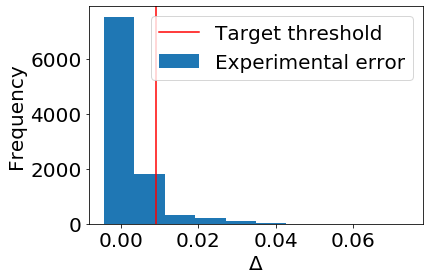

Layer 0


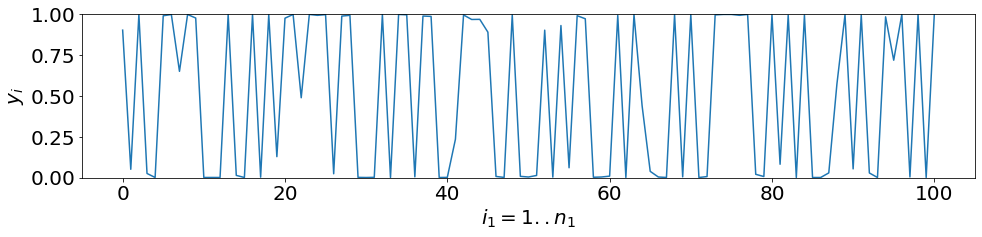

IntDer, Conv {'derivative': 4446.5234, 'smoothness': 26.458996}
Layer 1


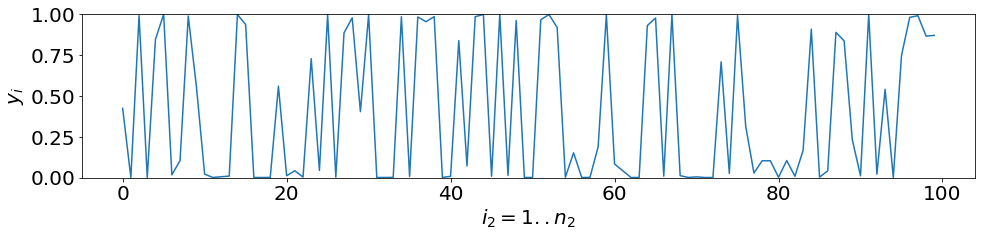

IntDer, Conv {'derivative': 1458.5785, 'smoothness': 8.831392}
Layer 2


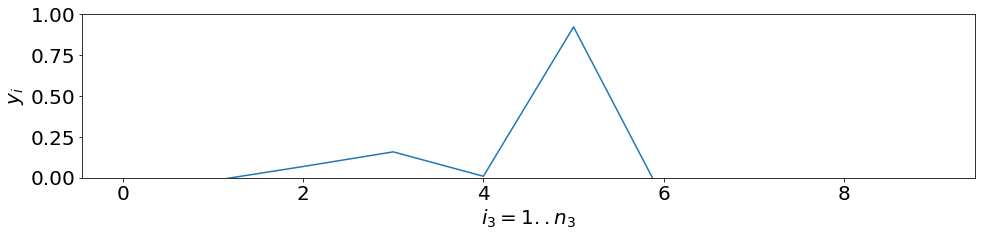

IntDer, Conv {'derivative': 64.30194, 'smoothness': 0.0}
True ans #0 5
P_empirical 0.10
q 0.25 D 4446.52 S 26.46
Bound Mean -0.000 Std 0.003
Exp   Mean 0.003 Std 0.006
Derivative must be < 100, consider increasing psi
Trying parameters {'N': 101, 'mu': 1e-10, 'lambda_': 1e-10, 'nu': 0, 'psi_d': 1e-07, 'psi_s': 9.999999999999999e-06}


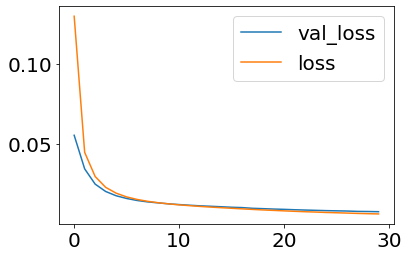

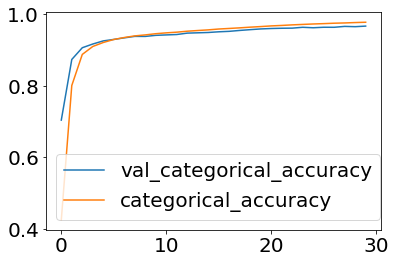

{'val_acc': 0.9666999995708465, 'train_acc': 0.9774833331505458, 'val_loss': 0.00758950156159699, 'train_loss': 0.00620606221879522}


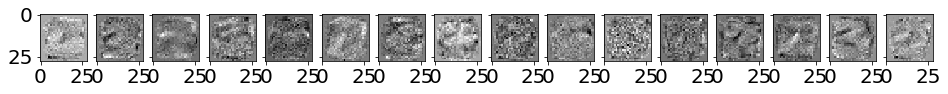

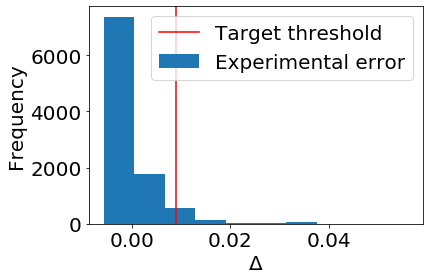

Layer 0


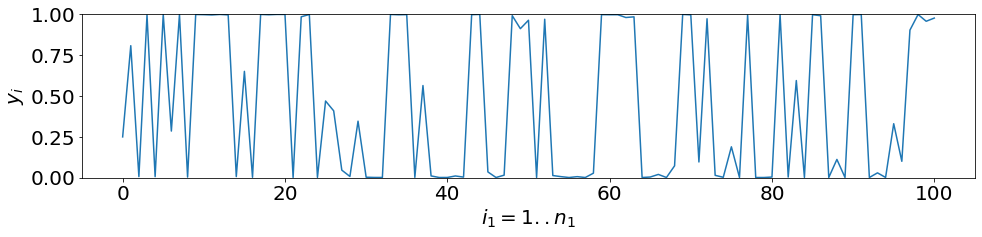

IntDer, Conv {'derivative': 3295.6082, 'smoothness': 19.641985}
Layer 1


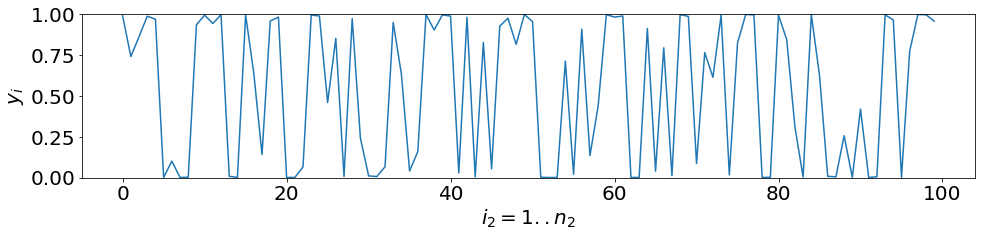

IntDer, Conv {'derivative': 1398.8218, 'smoothness': 8.534062}
Layer 2


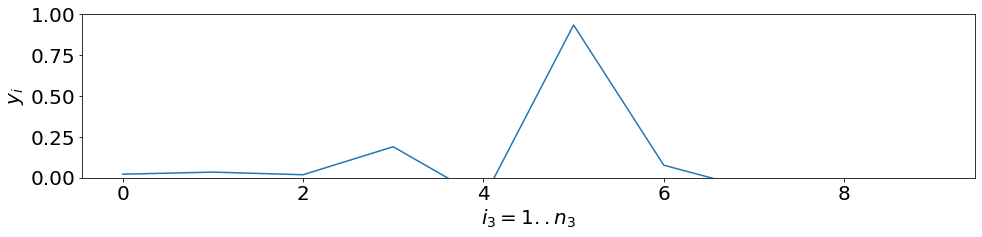

IntDer, Conv {'derivative': 68.458664, 'smoothness': 0.0}
True ans #0 5
P_empirical 0.06
q 0.29 D 3295.61 S 19.64
Bound Mean -0.001 Std 0.004
Exp   Mean 0.001 Std 0.005
Derivative must be < 100, consider increasing psi
Trying parameters {'N': 101, 'mu': 1e-10, 'lambda_': 1e-10, 'nu': 0, 'psi_d': 1e-06, 'psi_s': 9.999999999999999e-05}


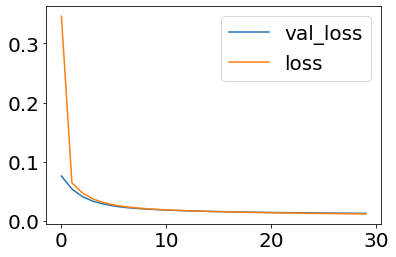

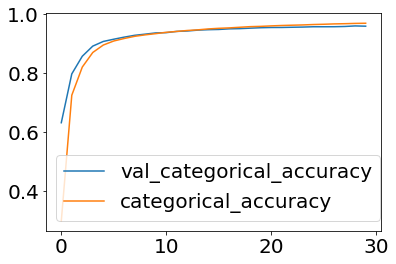

{'val_acc': 0.9591000020503998, 'train_acc': 0.9691000034411749, 'val_loss': 0.01284814765676856, 'train_loss': 0.011807610591252645}


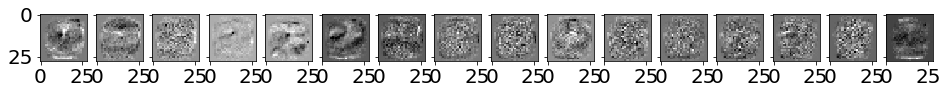

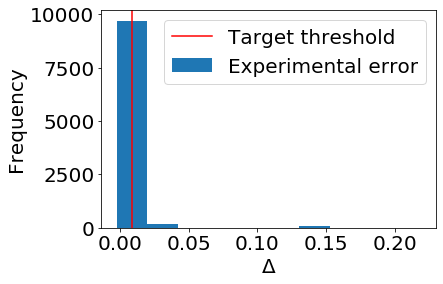

Layer 0


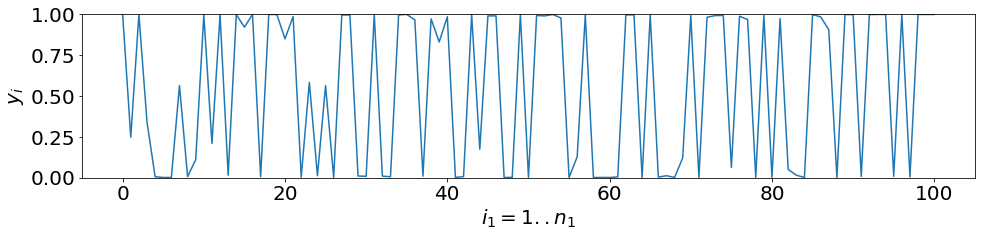

IntDer, Conv {'derivative': 1756.0033, 'smoothness': 10.521262}
Layer 1


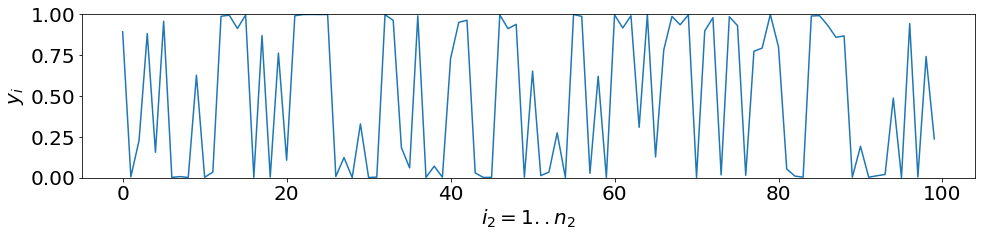

IntDer, Conv {'derivative': 1160.3394, 'smoothness': 6.9861927}
Layer 2


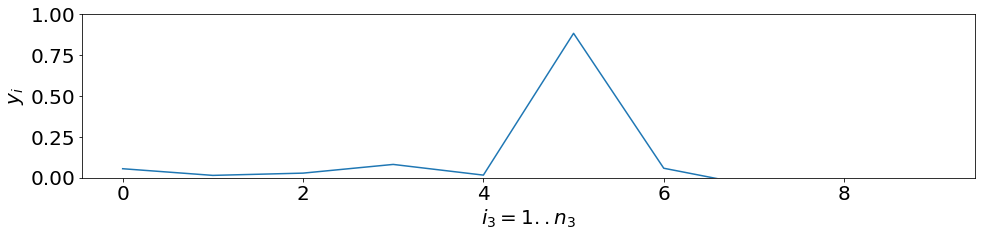

IntDer, Conv {'derivative': 63.53363, 'smoothness': 0.0}
True ans #0 5
P_empirical 0.10
q 0.29 D 1756.00 S 10.52
Bound Mean 0.000 Std 0.003
Exp   Mean 0.004 Std 0.015
Derivative must be < 100, consider increasing psi
Trying parameters {'N': 101, 'mu': 1e-10, 'lambda_': 1e-10, 'nu': 0, 'psi_d': 9.999999999999999e-06, 'psi_s': 0.001}


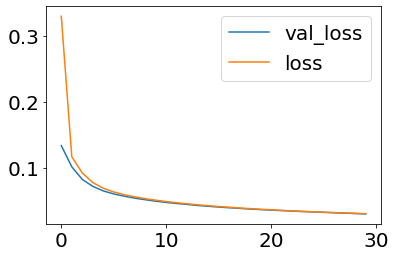

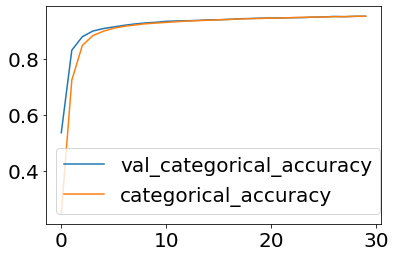

{'val_acc': 0.9518999993801117, 'train_acc': 0.9520499974489212, 'val_loss': 0.03034072145819664, 'train_loss': 0.030639050249010324}


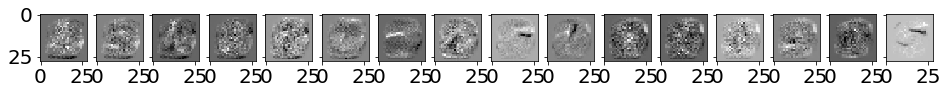

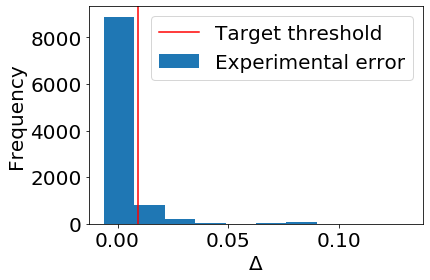

Layer 0


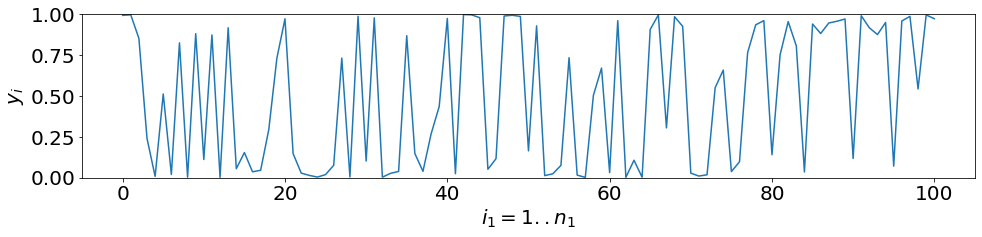

IntDer, Conv {'derivative': 414.2977, 'smoothness': 2.3773515}
Layer 1


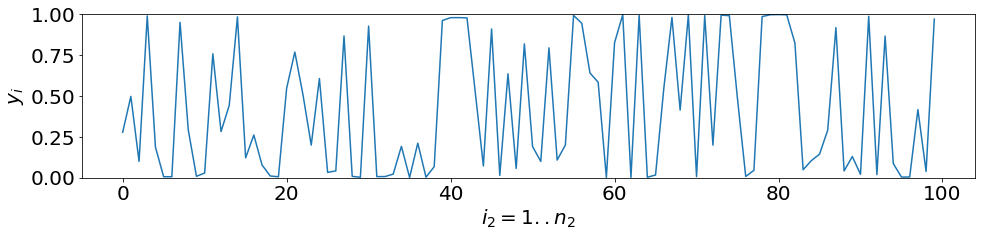

IntDer, Conv {'derivative': 683.25037, 'smoothness': 4.044161}
Layer 2


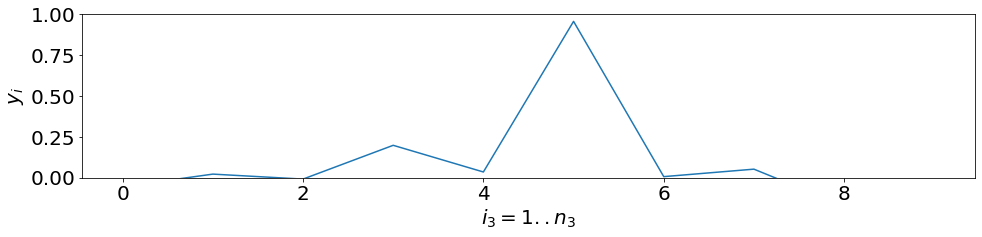

IntDer, Conv {'derivative': 68.69083, 'smoothness': 0.0}
True ans #0 5
P_empirical 0.10
q 0.31 D 414.30 S 2.38
Bound Mean -0.000 Std 0.004
Exp   Mean 0.003 Std 0.010
Derivative must be < 100, consider increasing psi
Trying parameters {'N': 101, 'mu': 1e-10, 'lambda_': 1e-10, 'nu': 0, 'psi_d': 9.999999999999999e-05, 'psi_s': 0.01}


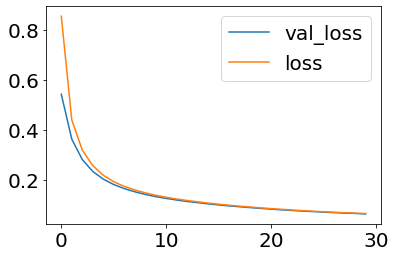

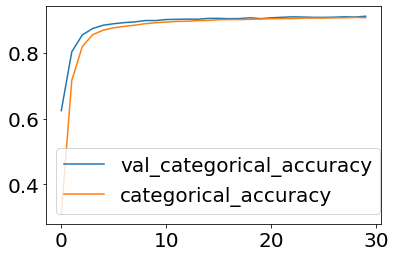

{'val_acc': 0.9122999906539917, 'train_acc': 0.907816669344902, 'val_loss': 0.06366540305316448, 'train_loss': 0.0650994148105383}


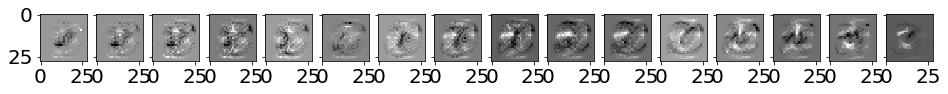

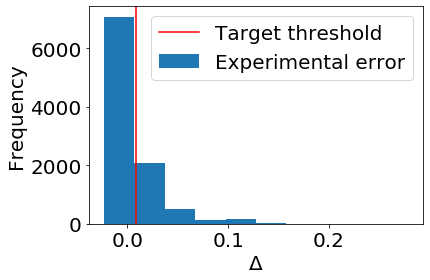

Layer 0


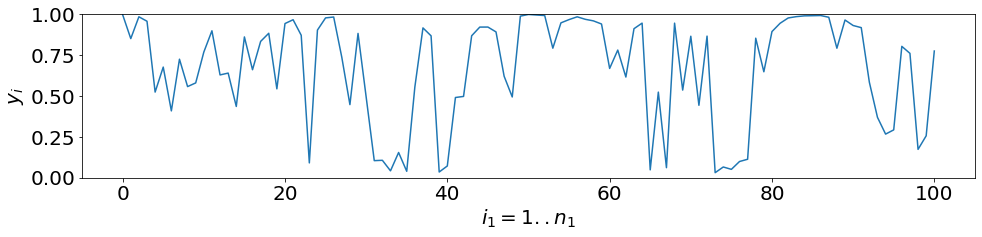

IntDer, Conv {'derivative': 66.90118, 'smoothness': 0.3160569}
Layer 1


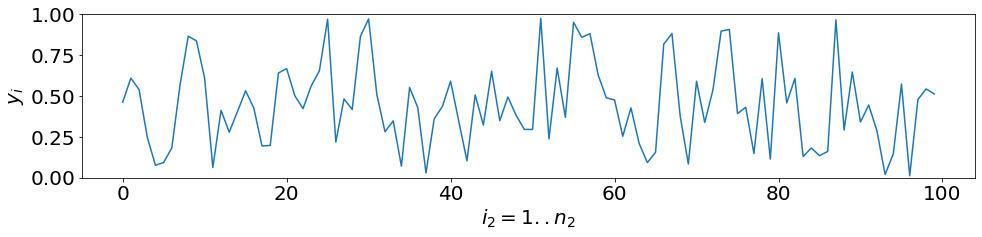

IntDer, Conv {'derivative': 143.30722, 'smoothness': 0.7457152}
Layer 2


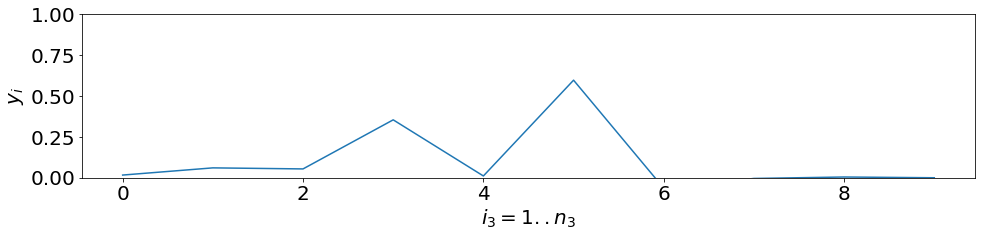

IntDer, Conv {'derivative': 81.07872, 'smoothness': 0.0}
True ans #0 5
P_empirical 0.27
q 0.33 D 66.90 S 0.32
Bound Mean 0.001 Std 0.013
Exp   Mean 0.009 Std 0.022
Must have eps^2 ~ Variance (have 2.52), otherwise Chebyshev would not work!, increasing n and lambda...
Trying parameters {'N': 201, 'mu': 1e-10, 'lambda_': 1e-09, 'nu': 0, 'psi_d': 9.999999999999999e-05, 'psi_s': 0.01}


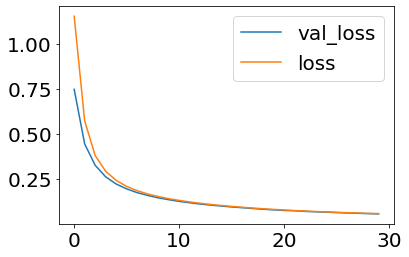

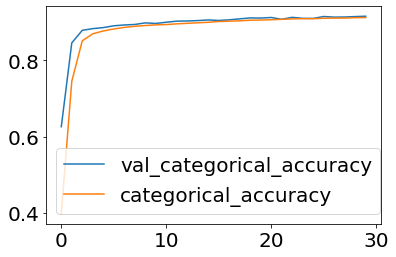

{'val_acc': 0.9163000047206878, 'train_acc': 0.912816662589709, 'val_loss': 0.05741967484354973, 'train_loss': 0.0590884143486619}


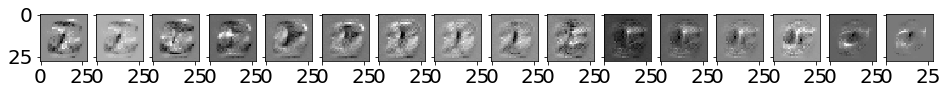

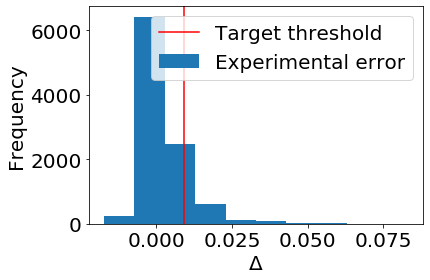

Layer 0


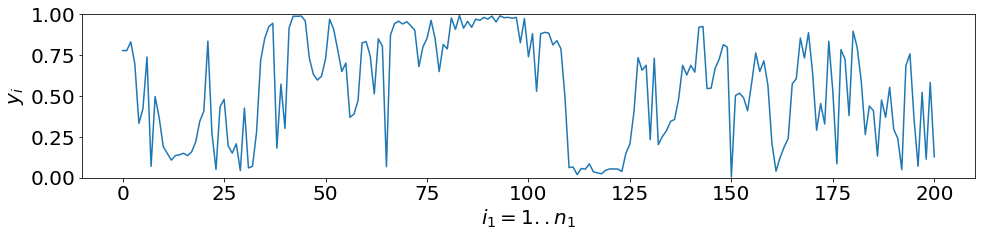

IntDer, Conv {'derivative': 69.59984, 'smoothness': 0.27054545}
Layer 1


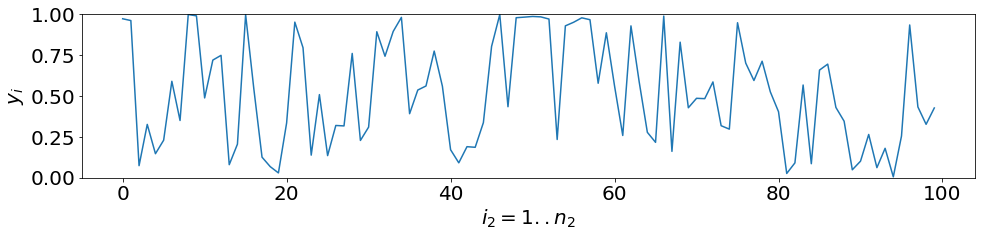

IntDer, Conv {'derivative': 94.488785, 'smoothness': 0.46306536}
Layer 2


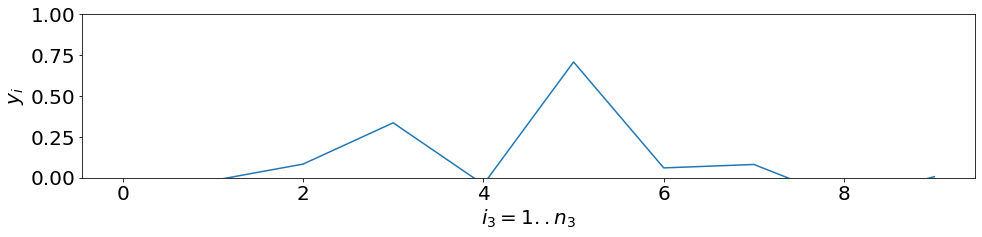

IntDer, Conv {'derivative': 81.70626, 'smoothness': 0.0}
True ans #0 5
P_empirical 0.14
q 0.21 D 69.60 S 0.27
Bound Mean 0.000 Std 0.006
Exp   Mean 0.003 Std 0.008
Must have eps^2 ~ Variance (have 0.47), otherwise Chebyshev would not work!, increasing n and lambda...
Trying parameters {'N': 301, 'mu': 1e-10, 'lambda_': 1e-08, 'nu': 0, 'psi_d': 9.999999999999999e-05, 'psi_s': 0.01}


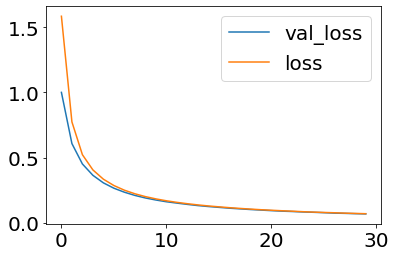

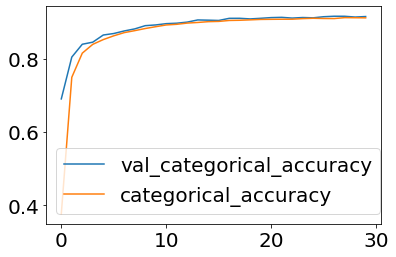

{'val_acc': 0.9148999989032746, 'train_acc': 0.9113333304723104, 'val_loss': 0.06768536269664764, 'train_loss': 0.06934878652294477}


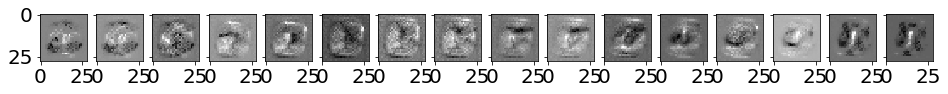

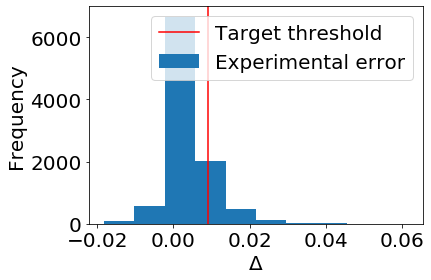

Layer 0


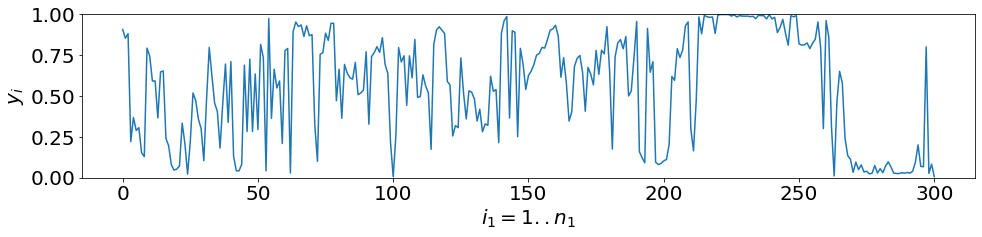

IntDer, Conv {'derivative': 81.16798, 'smoothness': 0.24661544}
Layer 1


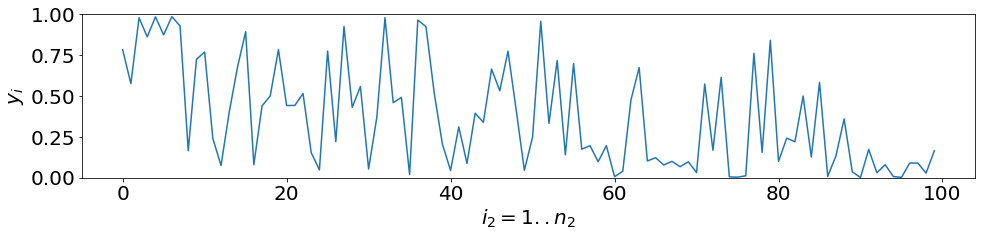

IntDer, Conv {'derivative': 125.24107, 'smoothness': 0.6308712}
Layer 2


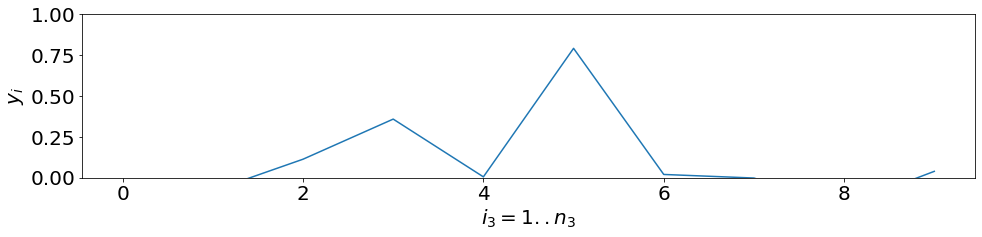

IntDer, Conv {'derivative': 77.71171, 'smoothness': 0.0}
True ans #0 5
P_empirical 0.15
q 0.19 D 81.17 S 0.25
Bound Mean 0.001 Std 0.005
Exp   Mean 0.004 Std 0.006
Must have eps^2 ~ Variance (have 0.46), otherwise Chebyshev would not work!, increasing n and lambda...
Trying parameters {'N': 401, 'mu': 1e-10, 'lambda_': 1e-07, 'nu': 0, 'psi_d': 9.999999999999999e-05, 'psi_s': 0.01}


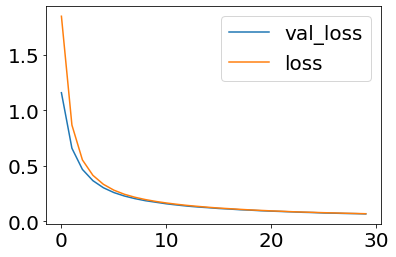

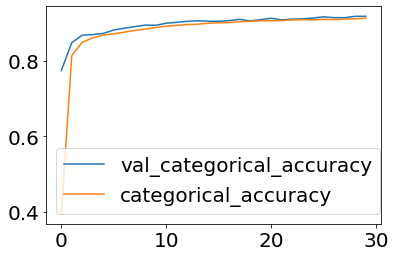

{'val_acc': 0.9169000029563904, 'train_acc': 0.9116500000158946, 'val_loss': 0.06695484444499016, 'train_loss': 0.06879450877507527}


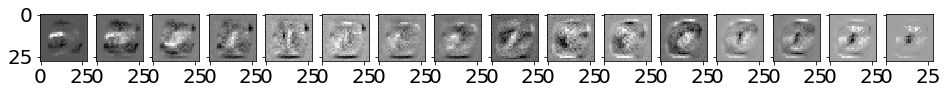

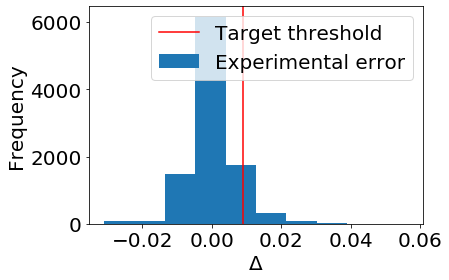

Layer 0


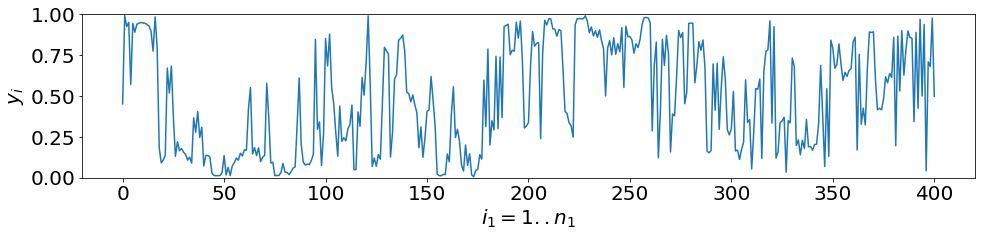

IntDer, Conv {'derivative': 87.62523, 'smoothness': 0.2492296}
Layer 1


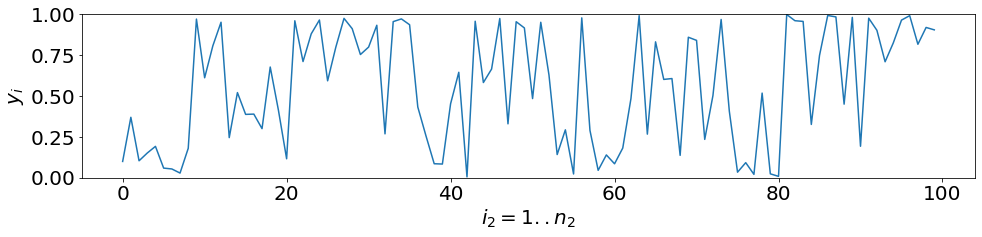

IntDer, Conv {'derivative': 107.09749, 'smoothness': 0.5248522}
Layer 2


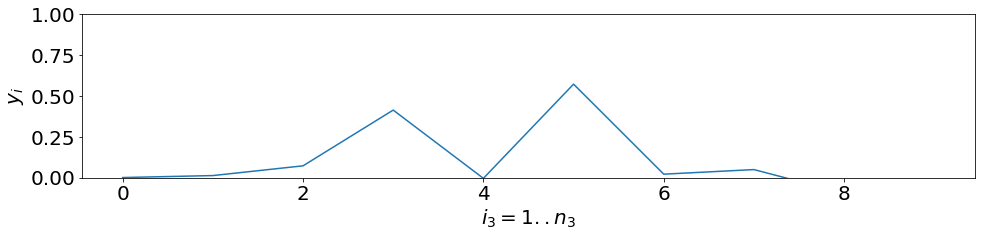

IntDer, Conv {'derivative': 75.01603, 'smoothness': 0.0}
True ans #0 5
P_empirical 0.08
q 0.08 D 87.63 S 0.25
Bound Mean -0.002 Std 0.007
Exp   Mean 0.000 Std 0.007
Must have eps^2 ~ Variance (have 0.44), otherwise Chebyshev would not work!, increasing n and lambda...
Trying parameters {'N': 501, 'mu': 1e-10, 'lambda_': 1e-06, 'nu': 0, 'psi_d': 9.999999999999999e-05, 'psi_s': 0.01}


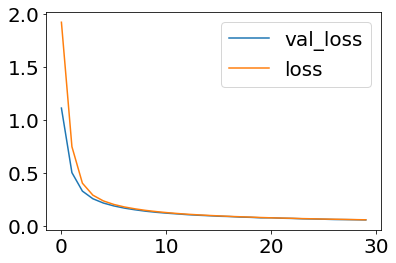

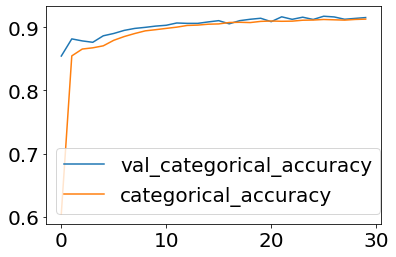

{'val_acc': 0.9156000018119812, 'train_acc': 0.9131333311398824, 'val_loss': 0.05768699757754803, 'train_loss': 0.058815659334262214}


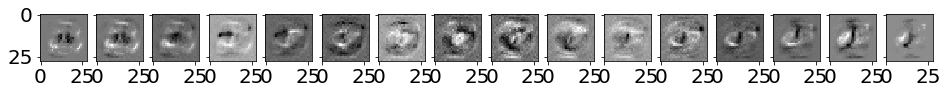

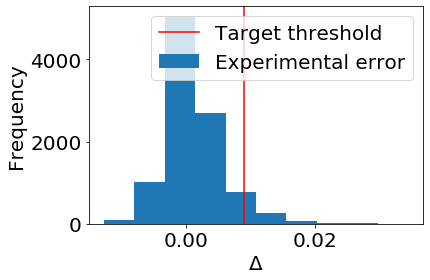

Layer 0


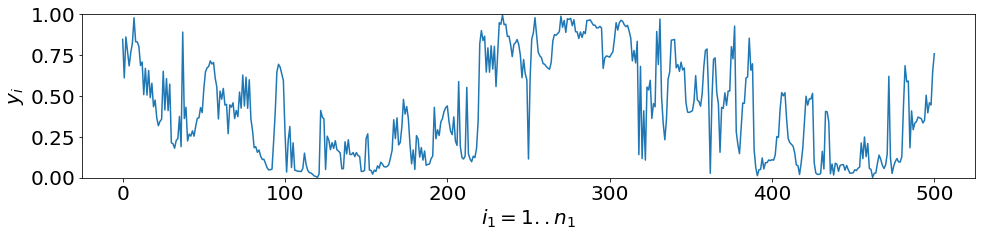

IntDer, Conv {'derivative': 84.84918, 'smoothness': 0.2152844}
Layer 1


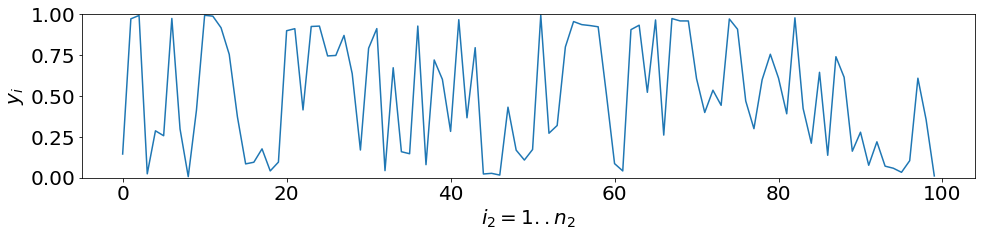

IntDer, Conv {'derivative': 73.335815, 'smoothness': 0.34913892}
Layer 2


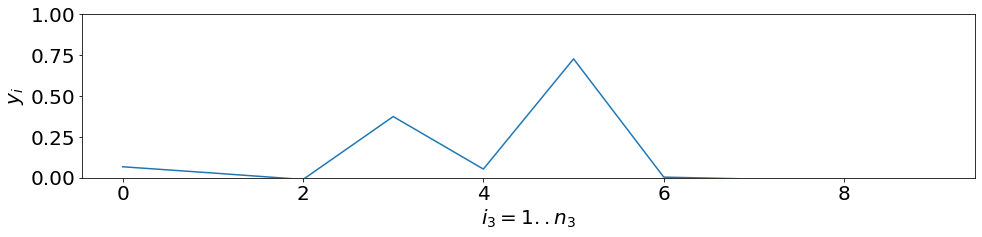

IntDer, Conv {'derivative': 72.48738, 'smoothness': 0.0}
True ans #0 5
P_empirical 0.06
q 0.16 D 84.85 S 0.22
Bound Mean 0.000 Std 0.004
Exp   Mean 0.001 Std 0.005
Need {'N': 501, 'mu': 1e-10, 'lambda_': 1e-06, 'nu': 0, 'psi_d': 9.999999999999999e-05, 'psi_s': 0.01}
To achieve eps=0.009000 delta=0.000010 fault tolerance


In [22]:
while True:
    print('Trying parameters %s' % str(parameters))
    exp = get_exp(**parameters)
    
    r = get_metrics(exp, to_run)
    print('P_empirical %.2f' % r['empirical_p'])
    print("q %.2f D %.2f S %.2f" % (r['q_1'], r['derivative'], r['smoothness']))
    print("Bound Mean %.3f Std %.3f" % (r['bound_mse_mean'], r['bound_mse_std']))
    print("Exp   Mean %.3f Std %.3f" % (r['exp_mse_mean'], r['exp_mse_std']))
    
    # adding data to the log
    log.append({'parameters': deepcopy(parameters), 'results': r})
    
    if r['q_1'] <= 1e-2:
        print("Q must be >0.01, consider increasing mu")
        parameters['mu'] *= 10
        continue
        
    # delta_0 from Prop. 3
    delta_0 = np.exp(-parameters['N'] * d_kl(alpha, p) * r['q_1'])
    if delta_0 > 1. / 6:
        print("Perturbation must be small but delta_0=%f, consider increasing n" % delta_0)
        inc_n()
        continue
        
    if r['derivative'] >= 100:
        print("Derivative must be < 100, consider increasing psi")
        parameters['psi_d'] *= 10
        parameters['psi_s'] *= 10
        continue
        
    if r['bound_mse_mean'] >= eps_target:
        print("Cannot do better than the mean, infeasible!")
        break
        
    # t from Prop. 5
    # sum to make it a scalar
    t = np.sum(eps_target - r['bound_mse_mean'])
    
    p_have = t ** (-2) * r['bound_mse_std'] ** 2
    if p_have >= 1. / 3:
        print("Must have eps^2 ~ Variance (have %.2f), otherwise Chebyshev would not work!, increasing n and lambda..." % p_have)
        parameters['lambda_'] *= 10
        inc_n()
        continue
        
    # now we have delta_0 < 1/6 and delta-delta_0 < 1 / 6 which makes delta < 1/3
    
    # computing the number of repetitions
    # (1/3)^(R/2)<delta_target -> delta_target => R = 2 log (1 / delta_target) / log(3)
    R = 2 * np.log(1 / delta_target) / np.log(3)
    
    print('Need %s' % str(parameters))
    print('To achieve eps=%f delta=%f fault tolerance' % (eps_target, delta_target))
    
    break

Empirically validating that $\delta<1/3$

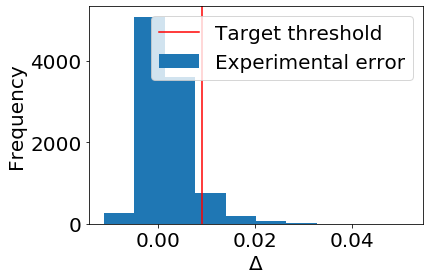

In [23]:
# taking the net
exp = get_exp(**parameters, do_print = False)
r = estimate_experimental_error(exp)

In [55]:
# all parameters
params = [x['parameters'] for x in log]

In [71]:
def difference(p1, p2):
    """ Which keys have different values in dicts p1, p2 ? """
    return ' and '.join([x for x in p1.keys() if p1[x] != p2[x]])

In [79]:
# list of what changed at each iteration
whatchanged = ['Start'] + [difference(x, y) for x, y in zip(params[:-1], params[1:])]
assert len(whatchanged) == len(params)

In [181]:
# creating colors for what changed
allchanged = list(set(whatchanged))
colors = ['magenta', 'green', 'blue', 'white']
def colorindex(s):
    return allchanged.index(s)
indices = [colorindex(s) for s in whatchanged]

# names for what changed
names = {'Start': '', 'N': '$N↑$', 'psi_d and psi_s': '$\psi↑$', 'N and lambda_': '$N↑,\,\lambda↑$'}

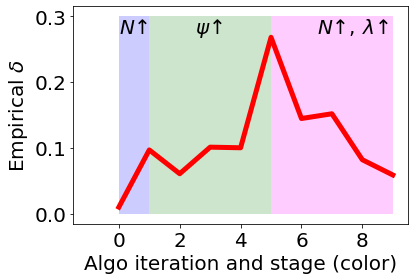

In [190]:
# plotting results
ax = plt.figure().gca()
from matplotlib.ticker import MaxNLocator
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.ylabel('Empirical $\delta$')
# experiment corresponds to theory
# plotting what changed + the iteration
# 
#plt.title()
plt.plot([x['results']['empirical_p'] for x in log], color = 'red', linewidth=5)#, label = 'Empirical $\delta$')
plt.xlabel('Algo iteration and stage (color)')

# showing phases of the algorithm
prev = None
for i in range(len(whatchanged)):
    idx = indices[i]
    mean_idx = np.mean(np.where(np.array(indices) == idx))
    name = names[whatchanged[i]]
    if name != prev:
        plt.text(mean_idx - 1, 0.275, name)
    plt.fill_between([i-1,i], 0, 0.3, color = colors[idx],
                     alpha = 0.2, linewidth = 0, label = names[whatchanged[i]])
    prev = name
plt.savefig('figures/thealgorithm.pdf', bbox_inches = 'tight')
#handles, labels = plt.gca().get_legend_handles_labels()
#by_label = OrderedDict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys())

#plt.plot(whatchanged)

In [13]:
print('Empirical probability: %.2f' % r['empirical_p'])
assert r['empirical_p'] < 1. / 3, "Tail bound must be valid"
print("If no errors, the test has passed successfully")

Empirical probability: 0.07
If no errors, the test has passed successfully


In [14]:
print('Final parameters: %s' % str(parameters))
print('Need %d repetitions of the network with median aggregation' % R)

Final parameters: {'N': 501, 'mu': 1e-10, 'lambda_': 1e-06, 'nu': 0, 'psi_d': 9.999999999999999e-05, 'psi_s': 0.01}
Need 20 repetitions of the network with median aggregation
